# Prophet 시계열 분석 예제 - 삼성전자 주가 예측(실생활 응용하지 말것)

`yfinance` 패키지 설치

## #01. 패키지

In [10]:
import yfinance as yf
from pandas import DataFrame
from matplotlib import pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import seaborn as sb
import datetime as dt
# 평균 절대 오차 함수
from sklearn.metrics import mean_absolute_error

In [2]:
plt.rcParams["font.family"] = "Malgun Gothic"

## #02. 데이터 불러오기

In [3]:
# origin = yf.download('005930.KS', start='2020-01-01', end='2020-12-31')
origin = yf.download('005930.KS', start='2020-01-01')
origin

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,55500.0,56000.0,55000.0,55200.0,50037.410156,12993228
2020-01-03,56000.0,56600.0,54900.0,55500.0,50309.351562,15422255
2020-01-06,54900.0,55600.0,54600.0,55500.0,50309.351562,10278951
2020-01-07,55700.0,56400.0,55600.0,55800.0,50581.292969,10009778
2020-01-08,56200.0,57400.0,55900.0,56800.0,51487.769531,23501171
...,...,...,...,...,...,...
2023-10-13,68000.0,68500.0,67700.0,68000.0,68000.000000,9724086
2023-10-16,67900.0,68500.0,66800.0,67300.0,67300.000000,12599299
2023-10-17,67700.0,69900.0,67400.0,69400.0,69400.000000,17299253


## #03. 데이터 전처리

### 필요한 필드만 추출

In [4]:
target_df = origin[["Close"]]
target_df.head()

,Close
Date,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0


### Prophet 라이브러리 형식에 맞추기

#### 날짜 인덱스를 일반 컬럼으로 변환

In [5]:
df = target_df.reset_index()
df.head()

,Date,Close
0,2020-01-02,55200.0
1,2020-01-03,55500.0
2,2020-01-06,55500.0
3,2020-01-07,55800.0
4,2020-01-08,56800.0


#### 필드 이름 변경

prophet 라이브러리의 요구 사항에 따라 날짜 필드의 이름을 `ds`로, 데이터의 필드 이름을 `y`로 변경.

In [6]:
df.rename(columns={"Date":'ds', "Close":"y"}, inplace=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      936 non-null    datetime64[ns]
 1   y       936 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.8 KB
None


,ds,y
0,2020-01-02,55200.0
1,2020-01-03,55500.0
2,2020-01-06,55500.0
3,2020-01-07,55800.0
4,2020-01-08,56800.0


## #04. 데이터 시각화

### 최고가/최저가 확인

In [7]:
df['y'].max(), df['y'].min()

(91000.0, 42500.0)

In [8]:
minmax = df.query("y == @df['y'].max() | y == @df['y'].min()")
minmax

,ds,y
55,2020-03-23,42500.0
253,2021-01-11,91000.0


### 라인 그래프

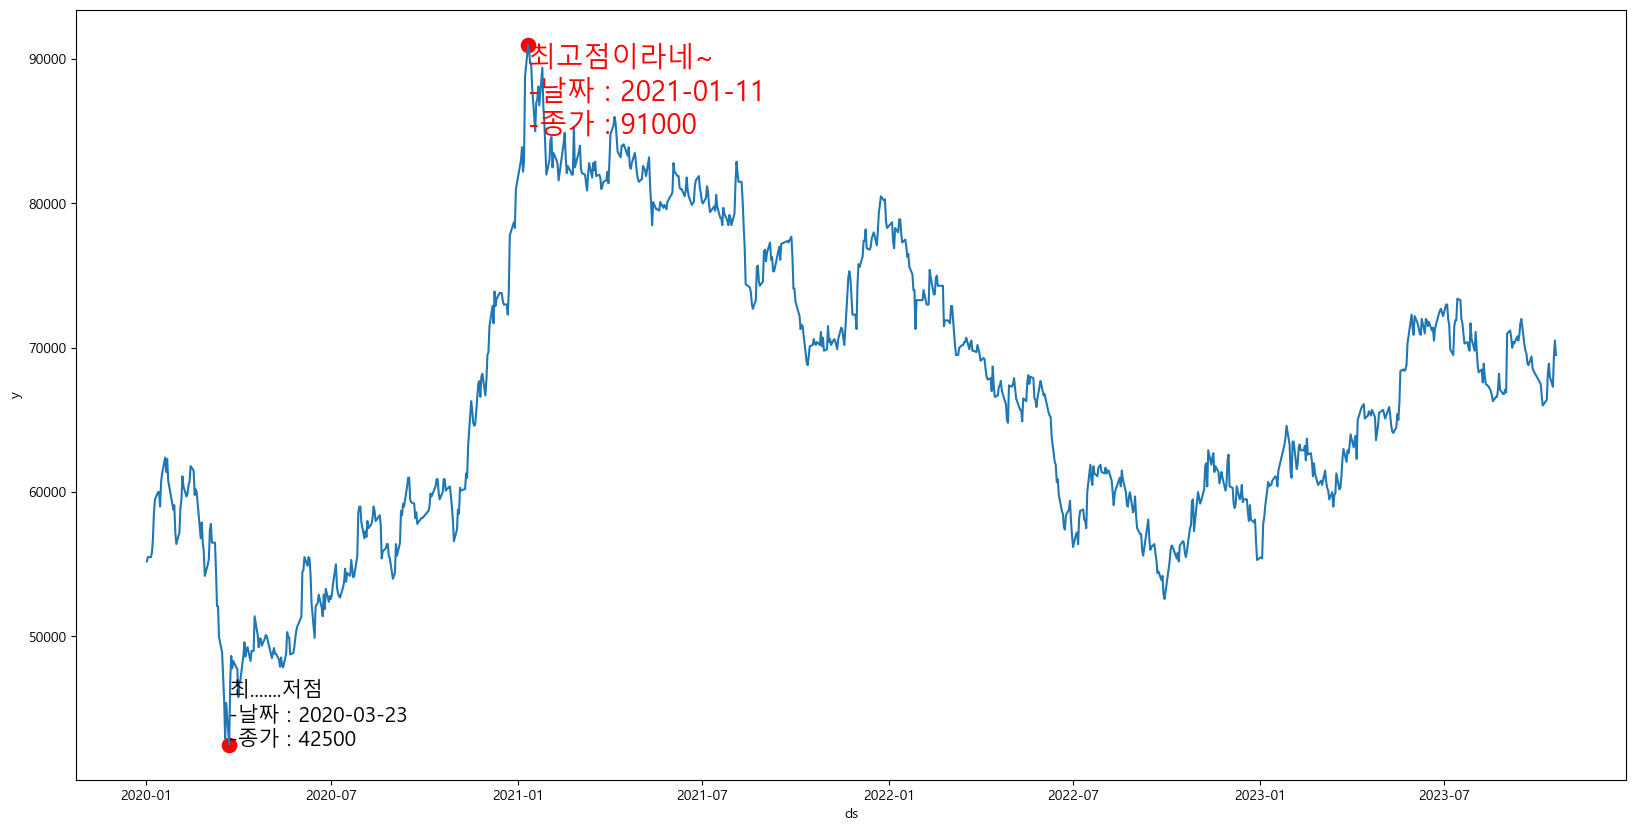

In [9]:
min_date = dt.datetime(2020, 3, 23)
max_date = dt.datetime(2021, 1, 11)

plt.figure(figsize=(20,10))
sb.lineplot(data=df, x='ds', y='y')
sb.scatterplot(data=minmax, x='ds', y='y', color='red', s=150, marker='o')

plt.text(min_date, 42500, '최.......저점 \n-날짜 : 2020-03-23 \n-종가 : 42500', fontsize=15)
plt.text(max_date, 91000, '최고점이라네~ \n-날짜 : 2021-01-11 \n-종가 : 91000', fontsize=20,
         color='red', verticalalignment='top', horizontalalignment='left')

plt.show()
plt.close()

## #05. 시계열 분석 수행

### 학습 모델 구축

14:16:16 - cmdstanpy - INFO - Chain [1] start processing
14:16:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:196: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)


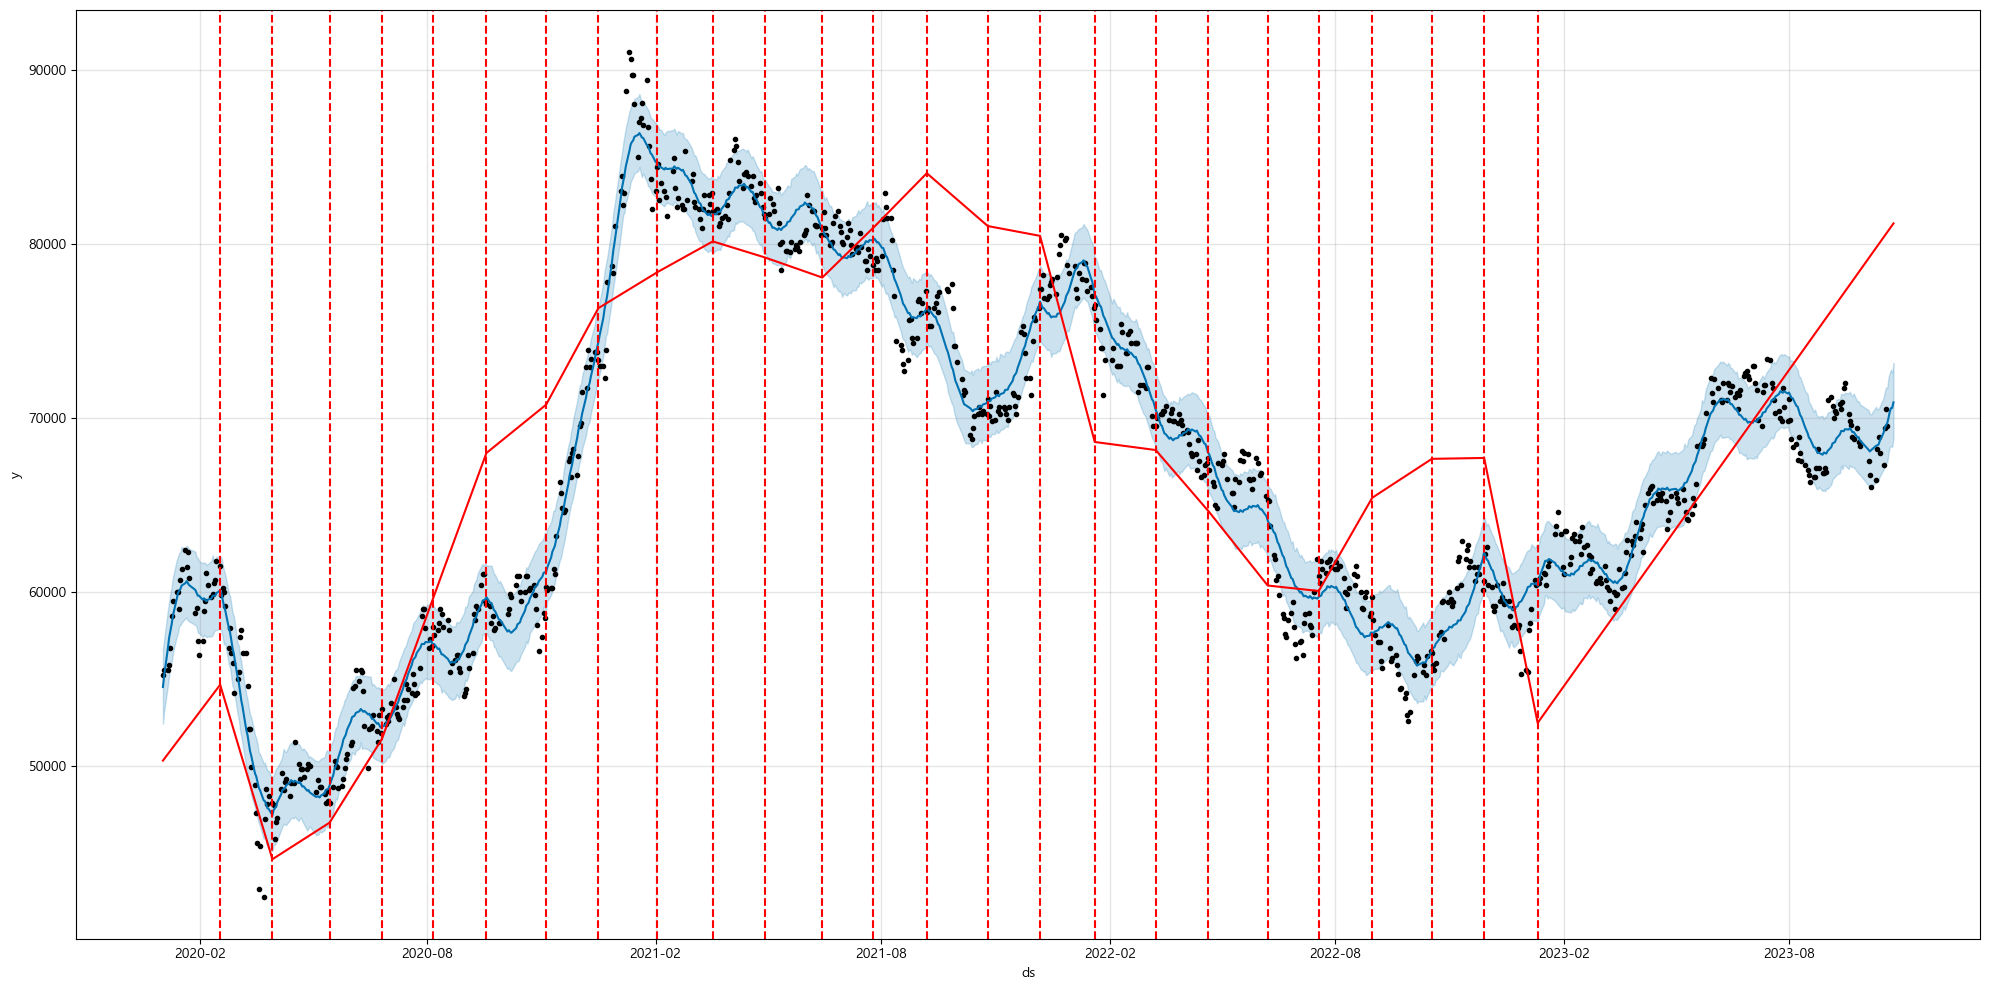

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


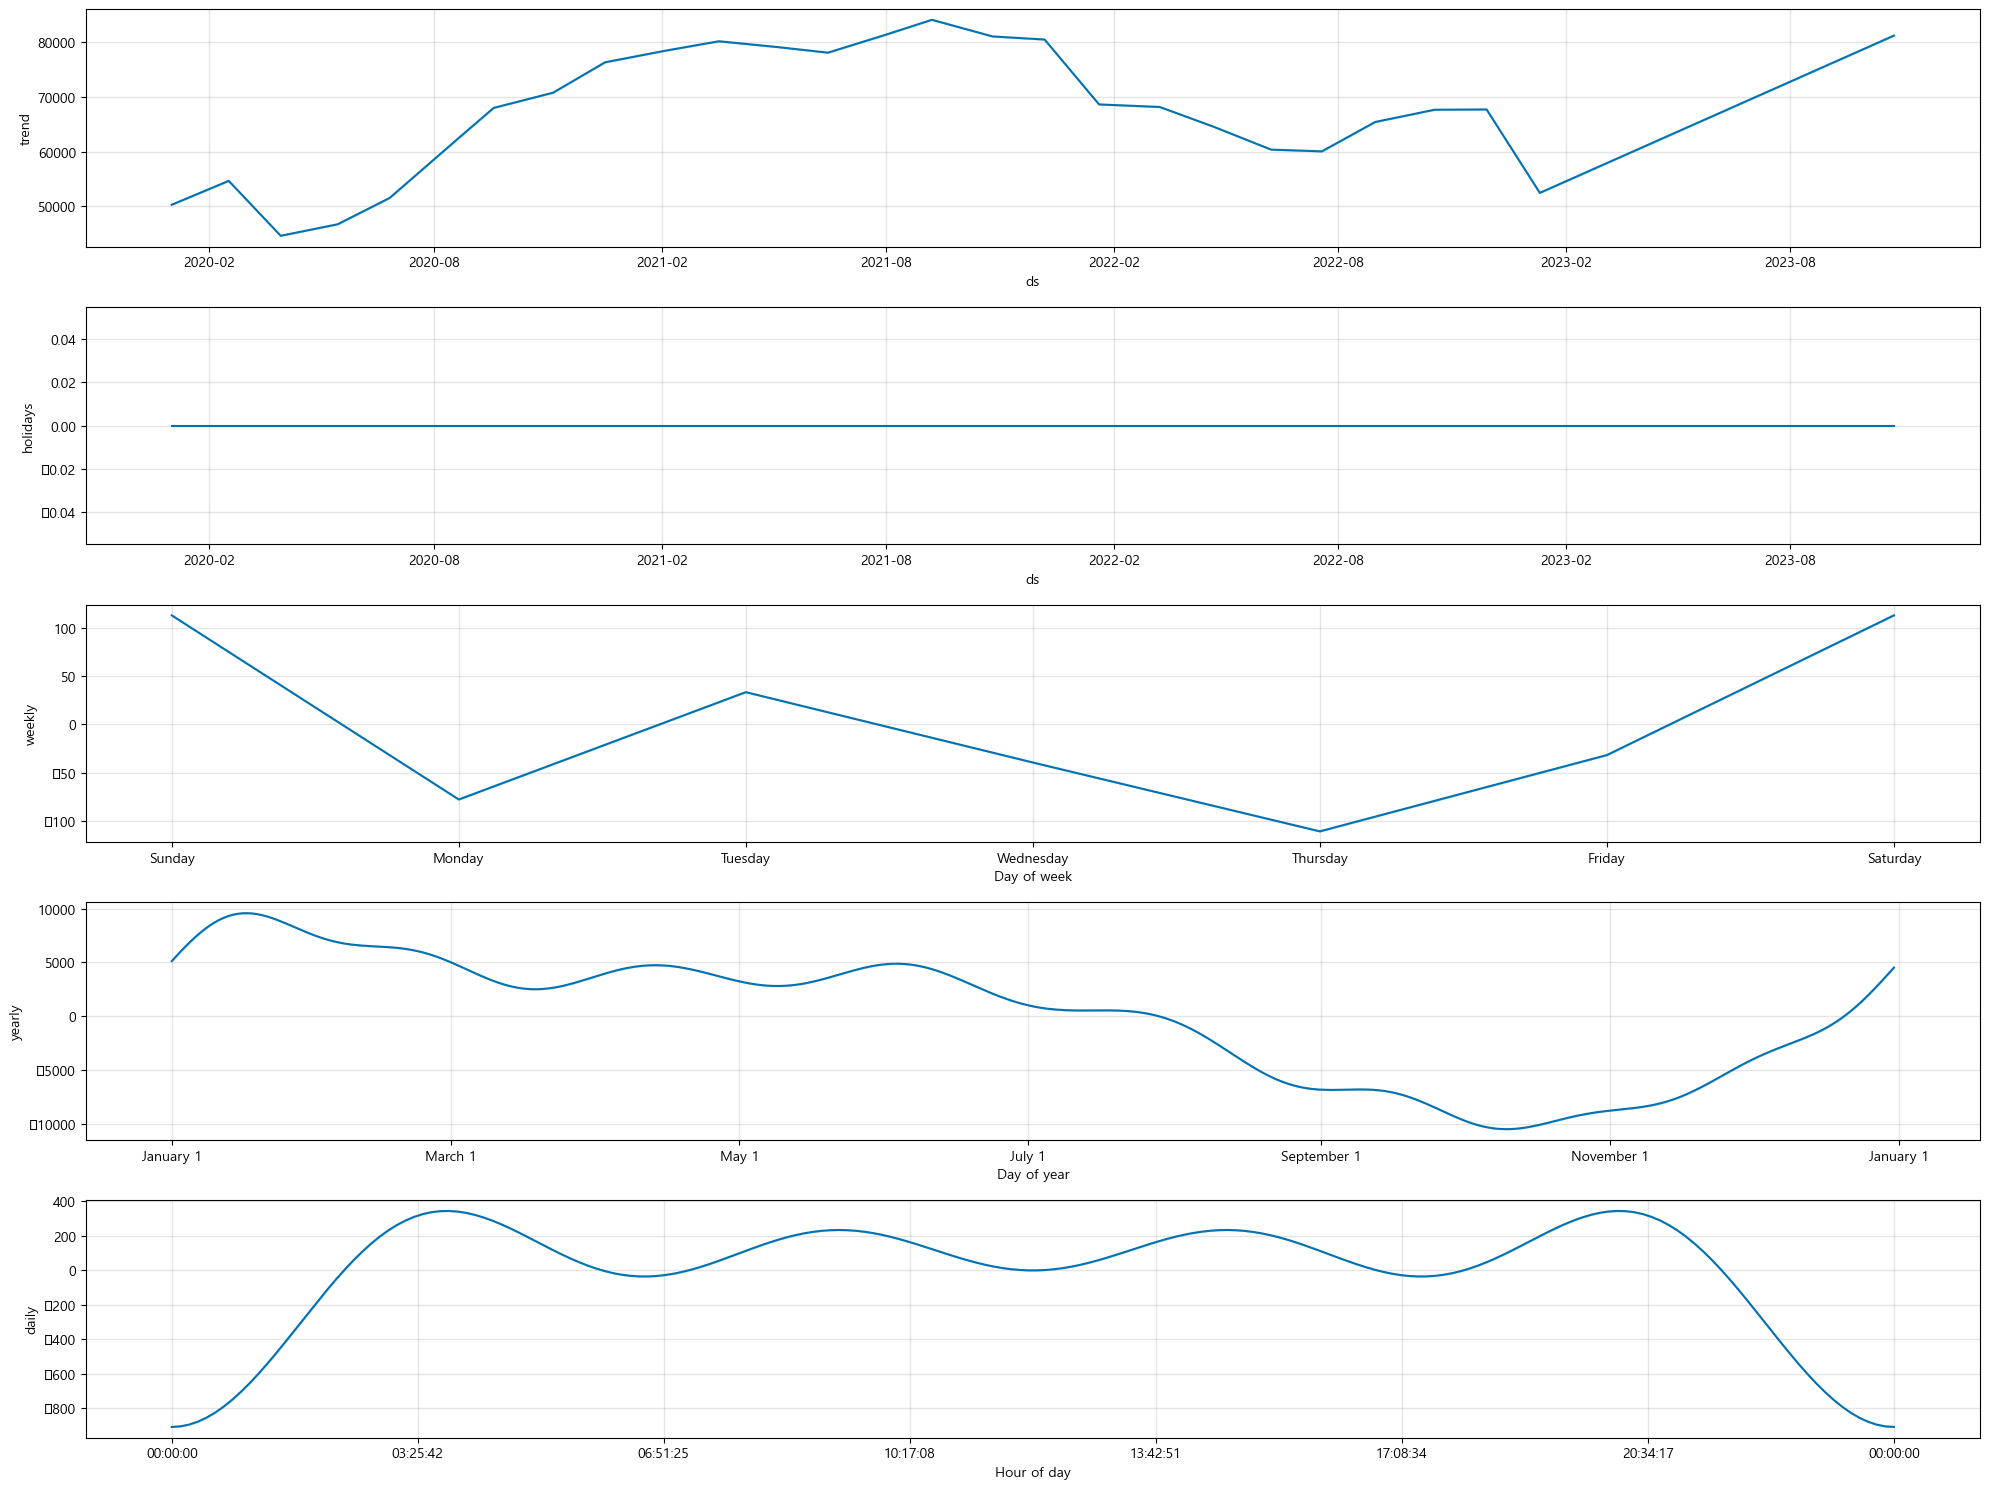

In [12]:
m = Prophet(
   # Trend
   changepoint_prior_scale=0.5,
   # Seasonality
   weekly_seasonality=True,
   yearly_seasonality=True,
   daily_seasonality=True
)

# 공휴일 데이터 추가
m.add_country_holidays(country_name='KR')
# 학습
m.fit(df)

# 5일간의 데이터 예측
future = m.make_future_dataframe(periods=5, freq="D")
forecast = m.predict(future)  # 예측값 생성

# 시각화
fig1 = m.plot(forecast, figsize=(20,10))
add_changepoints_to_plot(fig1.gca(), m, forecast)

fig2 = m.plot_components(forecast, figsize=(20,15))

## #06. 결과 평가

### 학습 데이터에 대한 예측 결과 추출

In [13]:
pred = forecast[['ds', 'yhat']]
pred

,ds,yhat
0,2020-01-02,54533.131098
1,2020-01-03,55184.139420
2,2020-01-06,56763.073655
3,2020-01-07,57372.617127
4,2020-01-08,57769.096380
...,...,...
936,2023-10-20,69984.011733
937,2023-10-21,70340.863742
938,2023-10-22,70552.052266
939,2023-10-23,70569.509439


### 실 데이터와 예측치 비교

In [18]:
df.columns

Index(['ds', 'y'], dtype='object')

In [19]:
pred.columns

Index(['ds', 'yhat'], dtype='object')

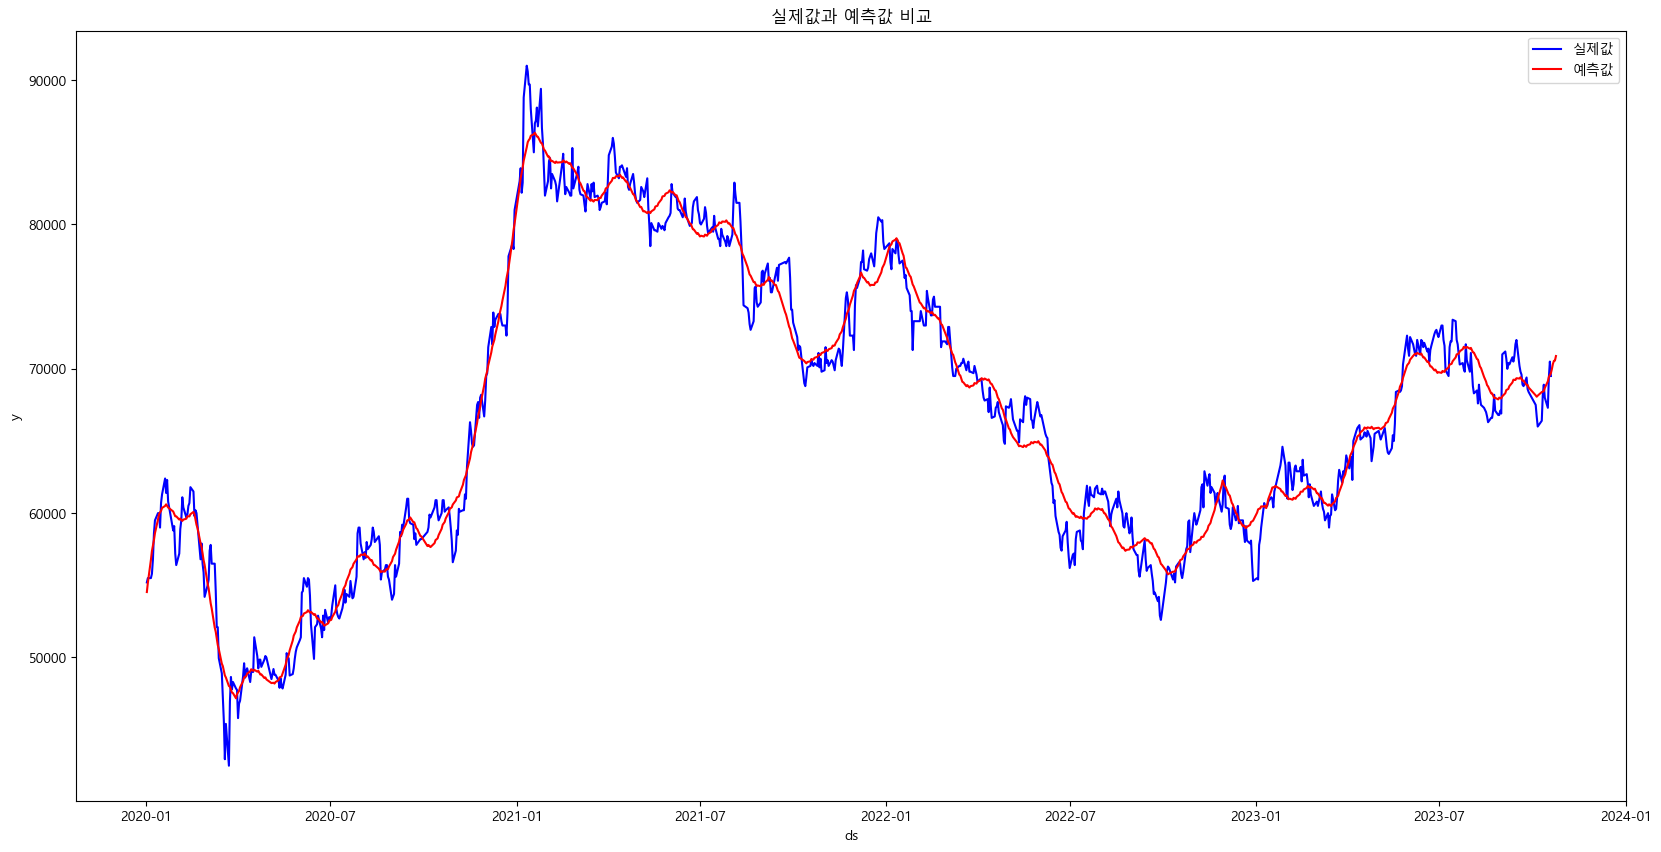

In [21]:
plt.figure(figsize=(20,10))
sb.lineplot(data=df, x='ds', y='y', label='실제값', color='blue')
sb.lineplot(data=pred, x='ds', y='yhat', label='예측값', color='red')
plt.title("실제값과 예측값 비교")
plt.legend()
plt.show()
plt.close()

### MAE(절대 평균 오차)

학습 모델의 하이퍼 파라미터를 조절해 이 값이 가장 적게 나타나는 학습 모델을 찾는다.

#### 최근 1년치 실제 데이터 추출

In [23]:
last_year = df.query('ds >= "2022-10-19"')
last_year.head()

,ds,y
688,2022-10-19,55800.0
689,2022-10-20,55500.0
690,2022-10-21,55900.0
691,2022-10-24,57500.0
692,2022-10-25,57700.0


#### 최근 1년치에 해당하는 예측값을 생성

In [24]:
# 예측값 생성
y_pred = m.predict(last_year)

In [27]:
y_pred.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Alternative holiday for Buddha's Birthday',
       'Alternative holiday for Buddha's Birthday_lower',
       'Alternative holiday for Buddha's Birthday_upper',
       'Alternative holiday for Chuseok',
       'Alternative holiday for Chuseok_lower',
       'Alternative holiday for Chuseok_upper',
       'Alternative holiday for Hangul Day',
       'Alternative holiday for Hangul Day_lower',
       'Alternative holiday for Hangul Day_upper',
       'Alternative holiday for Liberation Day',
       'Alternative holiday for Liberation Day_lower',
       'Alternative holiday for Liberation Day_upper',
       'Alternative holiday for Lunar New Year',
       'Alternative holiday for Lunar New Year_lower',
       'Alternative holiday for Lunar New Year_upper',
       'Alternative holiday for National Foundation Day',
       'Alternative holiday for National Foundation Day_lower',
       'Alternative holiday

In [28]:
y_pred['yhat']

0      56773.155890
1      56812.807769
2      57004.646235
3      57283.965720
4      57494.949237
           ...     
243    68677.186769
244    69131.344859
245    69434.154133
246    69560.645897
247    69694.870806
Name: yhat, Length: 248, dtype: float64

#### MAE 값 계산

In [29]:
mae = mean_absolute_error(last_year['y'].values,
                          y_pred['yhat'].values)

In [30]:
print("MAE : %.3f"%mae)

MAE : 1248.737
